In [2]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import patsy
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from sklearn import linear_model
import multiprocessing
##Code for analysis of fMRI experiment

In [3]:
%matplotlib inline

In [205]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

In [206]:
#process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

In [190]:
#made a mistake labeling these subject files. See notes
def get_sub_id(sub):        
    if sub == 'fd_126':
        sub_id = 'fd_125'
    elif sub == 'fd_127':
        sub_id = 'fd_126'
    else:
        sub_id = sub
    return sub_id

In [201]:
def perform_RL(trial_order,rew_trial,alpha,exp):
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
        
        if trial_type is not None:
            rew = rew_trial[n]
            delta[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V) 
            index[trial_type].append(count)
            count += 1 

    return V, delta, index

In [192]:
##function for building dataframe of relevant data for each subject
def build_df(sub,num_runs,exp):
    
    alpha = .1 #just some arbitrary alpha to get things going
    order_dict = order_dict_exp[exp]
    predictors = {'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}
    
    for i in range(1,num_runs+1):
        ##perform RL for the experimental condition
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha)

        #get rt data for this subject and run
        rts = rt_dict_exp[exp]
        rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]
        
        ##update predictors dict
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist
            predictors['V'].extend(V[key])
            predictors['PE'].extend(delta[key])
            predictors['cond'].extend([key]*len(V[key]))
            predictors['run'].extend(['run' + str(i)]*len(V[key]))
            predictors['trial_index'].extend(index[key])
            predictors['rt'].extend(rt_data[rt_data['order']==order_dict[key]]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['run','trial_index']) #get predictors in proper order

    #mean center RT
    predictors['rt'] = predictors['rt'] - predictors['rt'].mean()

    #Z-score trial index for each row
    for i in range(1,num_runs+1):
        run = 'run' + str(i)
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
        predictors.loc[predictors['run']==run,'trial_index'].mean()
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
        predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [200]:
##returns loss for linear regression
def regress(params,predictors,num_runs,exp):
    
    alpha = params[0] #learning rate
    beta = params[1:]
    
    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha)
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist
            predictors.loc[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key),'V'] = V[key]
            predictors.loc[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key),'PE'] = delta[key]

            
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V+run",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    return loss

In [20]:
params = np.transpose(np.zeros(X.shape[1]+1)) #initialize parameters to 0
params = (.1,0,0,0,0,0) #initialize parameters to 0

bounds = ((0,1),(None,None),(None,None),(None,None),(None,None),(None,None))
#res = minimize(regress, params, method='Powell',options={'disp': True})
#res = minimize(regress, params, method='BFGS',options={'disp': True})
#res = minimize(regress, params, method='SLSQP',bounds = bounds, options={'disp': True,'maxiter':200})

#minimizer_kwargs = {"method": "L-BFGS-B",'bounds':bounds}
#ret = basinhopping(regress, params, minimizer_kwargs=minimizer_kwargs,niter=50)


res = minimize(regress,params,bounds=bounds, method='L-BFGS-B', options={'disp': True})

TypeError: build_df() takes exactly 2 arguments (1 given)

In [327]:
res

  status: 0
 success: True
    nfev: 714
     fun: 1718.4515853621633
       x: array([  5.34427168e-02,  -1.04735376e+03,  -1.16936986e+01,
         7.56606351e+00,   7.04894734e+01,   1.17886548e+03])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-0.23917437,  0.02451088, -0.10184067, -0.02185061,  0.07646577,
        0.01630269])
     nit: 75

In [15]:
##loop through all subjects
def run_subjects(sub):
    sub_id = get_sub_id(sub)
    
    #get predictors dataframe
    num_runs = len(np.unique(ser_rts[ser_rts['sub']==sub_id]['run']))
    predictors = build_df(sub_id,num_runs)

    #initialize
    params = (.1,0,0,0,0,0) #initialize parameters to 0
    bounds = ((0,1),(None,None),(None,None),(None,None),(None,None),(None,None))

    #minimize
#     res = minimize(regress,params,args=(predictors,num_runs),bounds=bounds, method='L-BFGS-B', options={'disp': True})
    
    return predictors

In [27]:
# pool = multiprocessing.Pool(processes=30)
# output = pool.map(run_subjects,subjects)

[  3.84678794e-01   5.51152531e+01   2.25771659e+01   2.41422568e+01
   9.53527392e+00  -1.03489958e+03]
[  3.33529795e-01   7.59497829e+01   6.06802264e+01   7.94340480e+01
   3.14376574e+01   2.06234191e+03]


(array([ 2.,  1.,  2.,  4.,  4.,  4.,  6.,  2.,  1.,  2.]),
 array([-57.33210137, -44.27721909, -31.22233681, -18.16745453,
         -5.11257225,   7.94231003,  20.99719231,  34.05207459,
         47.10695688,  60.16183916,  73.21672144]),
 <a list of 10 Patch objects>)

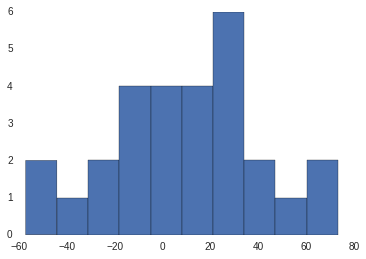

In [121]:
params = []
for n,o in enumerate(output):
    if o.success:
        params.append(o.x)    
params = np.array(params)

print np.mean(params, axis=0)
print np.std(params,axis = 0)
plt.hist(params[:,4])

In [110]:
#double check that linear regression code works (given a fixed alpha)
clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
clf.coef_

array([ -3.52411454, -13.38725855,  11.71133923,  -9.9083914 ,  24.31352455])

Now try to fit all subjects' data simultaneously

In [197]:
##function for building dataframe of relevant data for each subject
def build_df_all(num_runs, exp):
    order_dict = order_dict_exp[exp]
    alpha = .1
    predictors = {'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):

        ##perform RL for the experimental condition
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

        for sub in subjects:
            sub_id = get_sub_id(sub)
    
            #get rt data for this subject and run
            rts = rt_dict_exp[exp]
            rt_data = rts[(rts['sub']==sub_id) & (rts['run']==i) ]

            ##update predictors dict
            for key in V.keys():
                if len(rt_data[rt_data['order']==order_dict[key]]['rt'].values) != 10:
                    print len(rt_data[rt_data['order']==order_dict[key]]['rt'].values)
                    print i
                    print sub
                predictors['V'].extend(V[key])
                predictors['PE'].extend(delta[key])
                predictors['cond'].extend([key]*len(V[key]))
                predictors['subject'].extend([sub]*len(V[key]))
                predictors['run'].extend(['run' + str(i)]*len(V[key]))
                predictors['trial_index'].extend(index[key])
                predictors['rt'].extend(rt_data[rt_data['order']==order_dict[key]]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['subject','run','trial_index']) #get predictors in proper order

    #mean center RT
#     predictors['rt'] = predictors['rt'] - predictors['rt'].mean()
    
    #Z score RT for each subject
    for sub in subjects:
        predictors.loc[predictors['subject']==sub,'rt'] =  predictors.loc[predictors['subject']==sub,'rt'] - \
        predictors.loc[predictors['subject']==sub,'rt'].mean()  
        predictors.loc[predictors['subject']==sub,'rt'] =  predictors.loc[predictors['subject']==sub,'rt'] / \
        predictors.loc[predictors['subject']==sub,'rt'].std() 
        
    #Z-score trial index for each row
    for i in range(1,num_runs+1):
        run = 'run' + str(i)
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
        predictors.loc[predictors['run']==run,'trial_index'].mean()
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
        predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [198]:
##returns loss for linear regression
def regress_all(params,predictors,num_runs,exp):
    
    alpha = params[0] #learning rate
    beta = params[1:]

    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist 
            predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key) ,'V'] = V[key]*len(subjects)
            predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key),'PE'] = delta[key]*len(subjects)
    
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V+run",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    return loss
# regress_all(params,predictors,num_runs)

In [210]:
exp = 'sim'
params = [.1]
params.extend(np.zeros(5))
num_runs  = 3
predictors = build_df_all(num_runs,exp)
loss = regress_all(params,predictors,num_runs,exp)
bounds = [(0,1)]
for i in range(0,5):
    bounds.append((None,None))

#minimize
# res = minimize(regress_all,params,args=(predictors,num_runs,exp),bounds=bounds, method='L-BFGS-B', options={'disp': True})
minimizer_kwargs = {"method": "L-BFGS-B",'bounds':bounds,'args':(predictors,num_runs,exp)}
ret = basinhopping(regress_all, params, minimizer_kwargs=minimizer_kwargs,niter=50)


In [203]:
res

  status: 0
 success: True
    nfev: 154
     fun: 37.446722037604438
       x: array([ 0.38247556,  0.3620314 ,  0.12028201,  0.15694684,  0.00446865,
       -1.11607775])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -6.11066753e-05,  -2.48689958e-04,  -2.03925765e-04,
         8.17124146e-05,  -5.69855274e-04,  -1.57029945e-04])
     nit: 17

In [171]:
ret

                  nfev: 7196
 minimization_failures: 0
                   fun: 37.446722031145107
                     x: array([ 0.38249334,  0.36203726,  0.12028474,  0.15693011,  0.00447598,
       -1.11605044])
               message: ['requested number of basinhopping iterations completed successfully']
                   nit: 50

In [208]:
res

  status: 0
 success: True
    nfev: 182
     fun: 37.710933119262073
       x: array([ 0.25209737,  0.16060626,  0.25796919,  0.38188396,  0.08537042,
       -1.05208584])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([  3.55271368e-06,   7.10542736e-07,  -2.84217094e-06,
        -2.13162821e-06,   5.68434189e-06,   0.00000000e+00])
     nit: 20

In [211]:
ret

                  nfev: 8344
 minimization_failures: 0
                   fun: 37.710933119262073
                     x: array([ 0.25209737,  0.16060626,  0.25796919,  0.38188396,  0.08537042,
       -1.05208584])
               message: ['requested number of basinhopping iterations completed successfully']
                   nit: 50